# Script to evaluate the ML-Models

Setup (load automl-models.pickle)

In [1]:
import pickle
import csv
from os import listdir
from os.path import isfile, join

with open(r"../app/_meta.csv") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  list_qualities = list()
  for line in csv_reader:
    list_qualities.append(line[0])
  list_qualities = list_qualities[1:]


with open(r"../app/ml-models.pickle", "rb") as input_file:
  ml_models = pickle.load(input_file)


dataset_loc = 'training-data/'

datasets_names = [f for f in listdir(dataset_loc) if isfile(join(dataset_loc, f))]

Inspect the score:

In [2]:
sum_scores = 0
for key, value in ml_models.items():
  print(key, ':', value.get('model').best_loss)
  sum_scores += value.get('model').best_loss
print()
print('Average Loss:', "{:.2f}".format(100*sum_scores/len(ml_models), 2), '%')

TPOT : 0.0
auto-sklearn : 0.009090909090909084
Hyperopt-Sklearn : 0.0
H2O AutoML : 0.0
FLAML : 0.18736842105263157
AutoGluon : 0.0
ATM : 0.16578947368421054
TransmogrifAI : 0.0

Average Loss: 4.53 %


Test with a random dataset:

In [3]:
import openml as oml

dataset = oml.datasets.get_dataset(12)

In [4]:
import pandas as pd

t = dict()

for quality in list_qualities:
  t[quality] = [dataset.qualities.get(quality)]
test_df = pd.DataFrame(t)

for key, value in ml_models.items():
  aml = value.get('model')
  print(key, ':', aml.predict_proba(test_df))

TPOT : [[1. 0.]]
auto-sklearn : [[9.99856444e-01 1.43556226e-04]]
Hyperopt-Sklearn : [[0.48253676 0.51746324]]
H2O AutoML : [[0.99834307 0.00165693]]
FLAML : [[0.61801507 0.38198493]]
AutoGluon : [[1. 0.]]
ATM : [[0.5071862  0.49281383]]
TransmogrifAI : [[1. 0.]]


In [5]:
import matplotlib.pyplot as plt
import lightgbm as lgb

plt.rcParams["figure.figsize"] = (4, 3) # (w, h)

def make_feature_importance_diagram(feature_names_in, feature_importances, name):
  sorted_idx = feature_importances.argsort()[-5:]
  fig, ax = plt.subplots()
  ax.barh(
    feature_names_in[sorted_idx],
    feature_importances[sorted_idx],
    height=0.5,

  )
  plt.xlabel("Feature importance")
  plt.ylabel("Features")
  plt.savefig('graphs/feature-importances/{}-features.png'.format(name), dpi=300, bbox_inches="tight")

def make_feature_importance_diagram_lgb(model, name):
  importance_types = ['gain', 'split']
  for importance_type in importance_types:
    lgb.plot_importance(model.estimator, max_num_features=5, importance_type=importance_type, title='', height=0.5, grid=False, figsize=(4,3))
    plt.savefig('graphs/feature-importances/{}-features ({}).png'.format(name, importance_type), dpi=300, bbox_inches="tight")

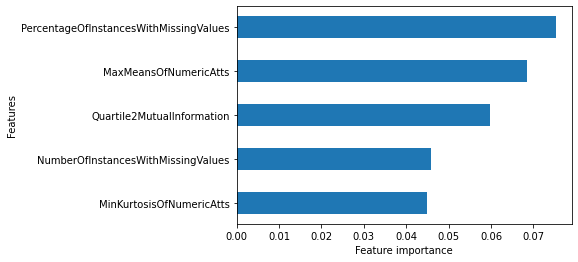

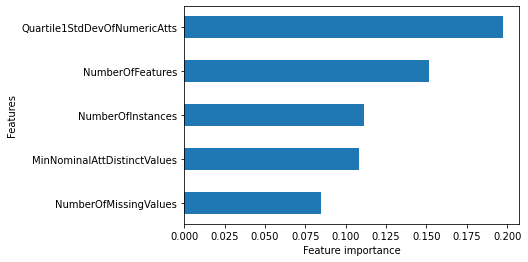

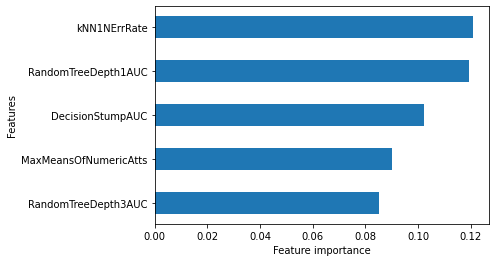

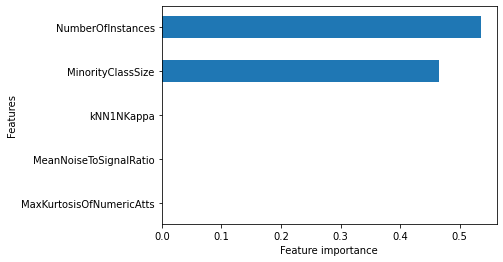

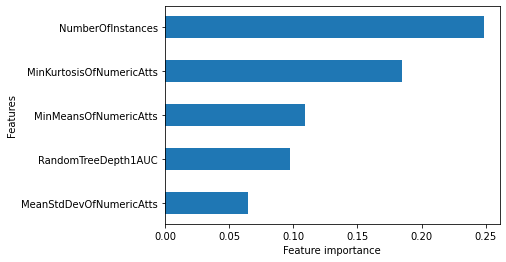

In [6]:
#TPOT
feature_names_in = ml_models['TPOT'].get('model').model.estimator.feature_names_in_
make_feature_importance_diagram(feature_names_in, ml_models['TPOT'].get('model').model.estimator.feature_importances_, 'TPOT')

#Hyperopt-Sklearn
make_feature_importance_diagram(feature_names_in, ml_models['Hyperopt-Sklearn'].get('model').model.estimator.feature_importances_, 'Hyperopt-Sklearn')

#AutoGluon
make_feature_importance_diagram(feature_names_in, ml_models['AutoGluon'].get('model').model.estimator.feature_importances_, 'AutoGluon')

#ATM
make_feature_importance_diagram(feature_names_in, ml_models['ATM'].get('model').model.estimator.feature_importances_, 'ATM')

#TransmogrifAI
make_feature_importance_diagram(feature_names_in, ml_models['TransmogrifAI'].get('model').model.estimator.feature_importances_, 'TransmogrifAI')

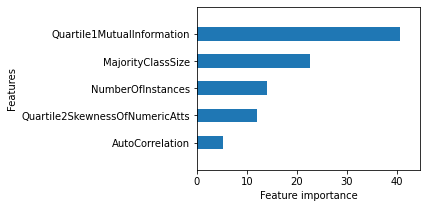

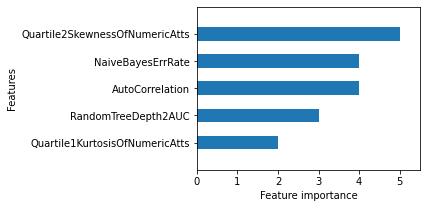

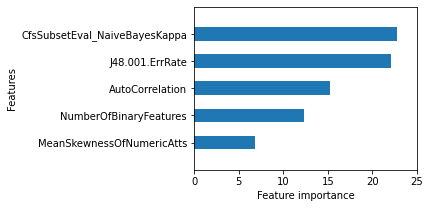

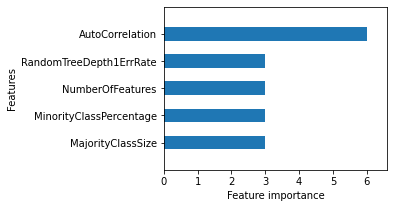

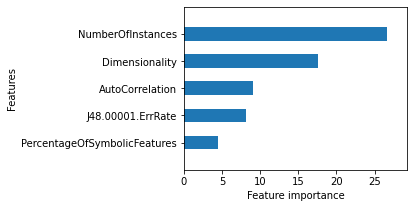

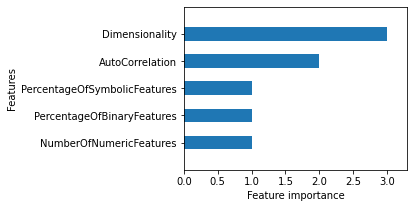

In [7]:
# auto-sklearn
make_feature_importance_diagram_lgb(ml_models['auto-sklearn'].get('model').model, 'auto-sklearn')

#H20 AutoML
make_feature_importance_diagram_lgb(ml_models['H2O AutoML'].get('model').model, 'H2O AutoML')

# FLAML
make_feature_importance_diagram_lgb(ml_models['FLAML'].get('model').model, 'FLAML')

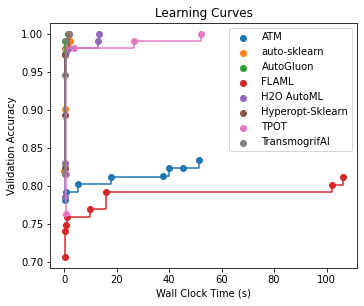

In [13]:
from cProfile import label
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5.5, 4.5) # (w, h)

logs = [
'ATM-data.csv2022-09-09 19:02:59.228622.log',
'auto-sklearn-data.csv2022-09-09 18:52:58.964856.log',
'AutoGluon-data.csv2022-09-09 19:00:59.162002.log',
'FLAML-data.csv2022-09-09 18:58:59.078054.log',
'H2O AutoML-data.csv2022-09-09 18:56:59.124596.log',
'Hyperopt-Sklearn-data.csv2022-09-09 18:54:59.051468.log',
'TPOT-data.csv2022-09-09 18:50:58.856981.log',
'TransmogrifAI-data.csv2022-09-09 19:04:59.343437.log']

for log in logs:
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='logs/' + log, time_budget=60*2)
    plt.scatter(time_history, 1 - np.array(valid_loss_history), label=log[0:-39])
    plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')

plt.title('Learning Curves')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('graphs/learning-curves.png', dpi=300)